In [644]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.ndimage.filters import uniform_filter1d
import os
import pickle

In [645]:
log_file = 'log_batch.pkl'
logs_dict = pickle.load(open(log_file, 'rb'))
print(list(logs_dict.keys()))

loss = logs_dict['loss']
val = logs_dict['val']
rot_loss = logs_dict['rot_loss']
dx_loss = logs_dict['dx_loss']
dy_loss = logs_dict['dy_loss']
rot_embedding, x_embedding, y_embedding = logs_dict['embeddings']

avg_len = max(1, int(0.2 * len(loss)))
print(f'Smoothing length: {avg_len}')

['loss', 'val', 'rot_loss', 'dx_loss', 'dy_loss', 'embeddings']
Smoothing length: 240


In [646]:
start_idx = 0

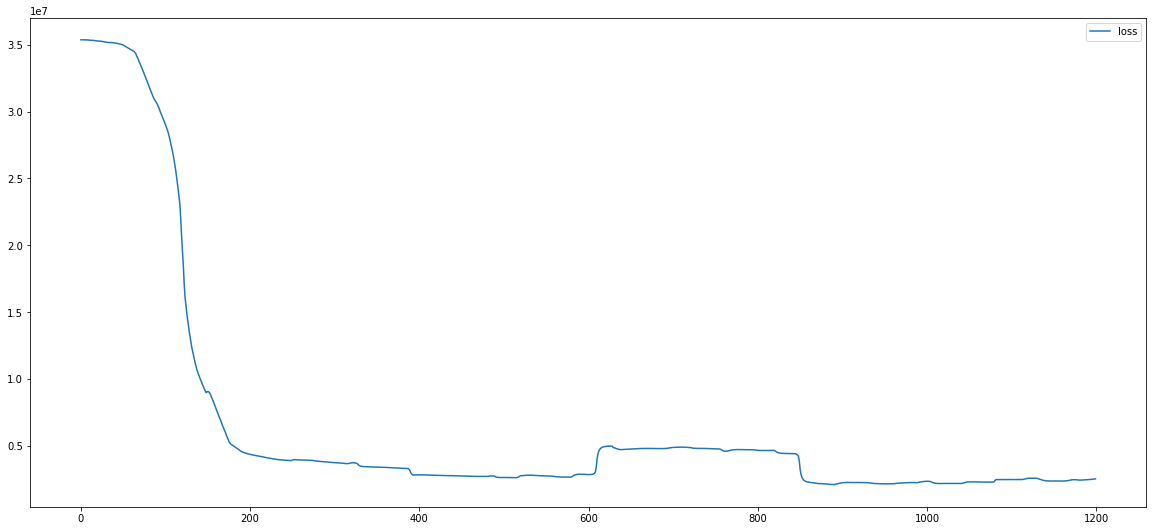

In [647]:
plt.plot(uniform_filter1d(loss[start_idx:], size=avg_len), label = "loss")
plt.legend()
plt.show()

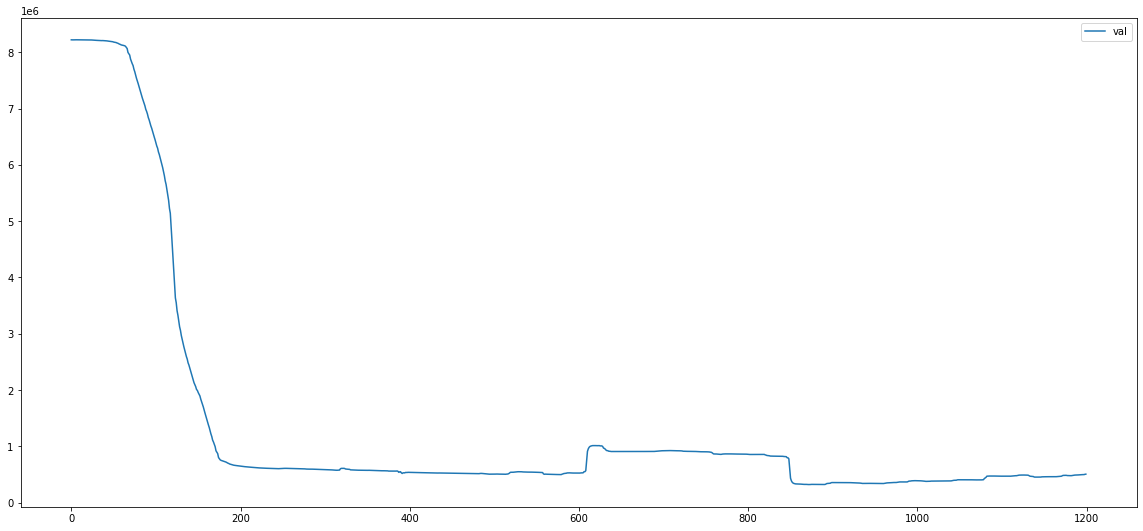

In [648]:
plt.plot(uniform_filter1d(val[start_idx:], size=avg_len), label = "val")
plt.legend()
plt.show()

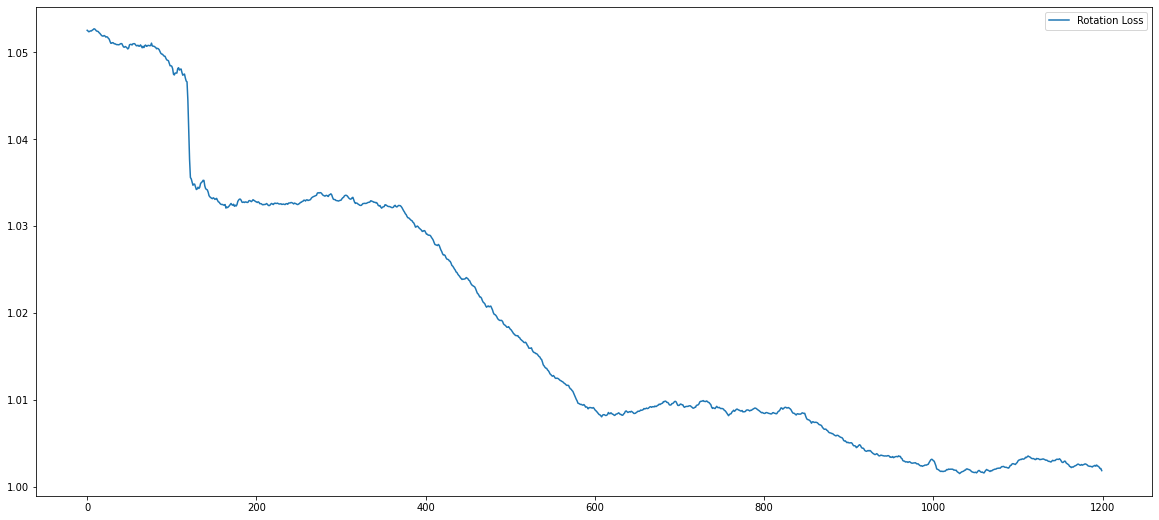

In [649]:
plt.plot(uniform_filter1d(rot_loss[start_idx:], size=avg_len), label = "Rotation Loss")
plt.legend()
plt.show()

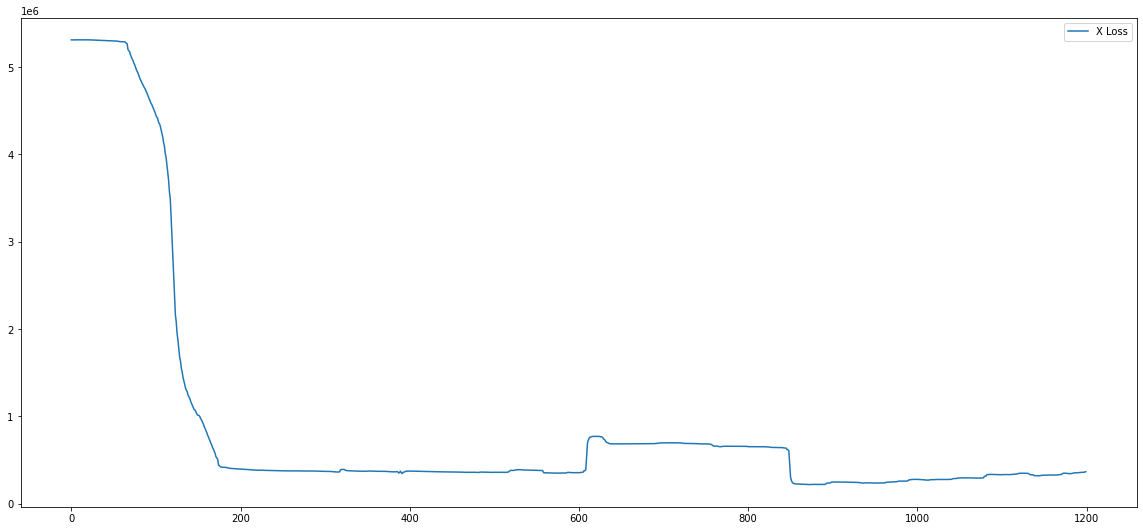

In [650]:
plt.plot(uniform_filter1d([float(v) for v in dx_loss[start_idx:]], size=avg_len), label = "X Loss")
plt.legend()
plt.show()

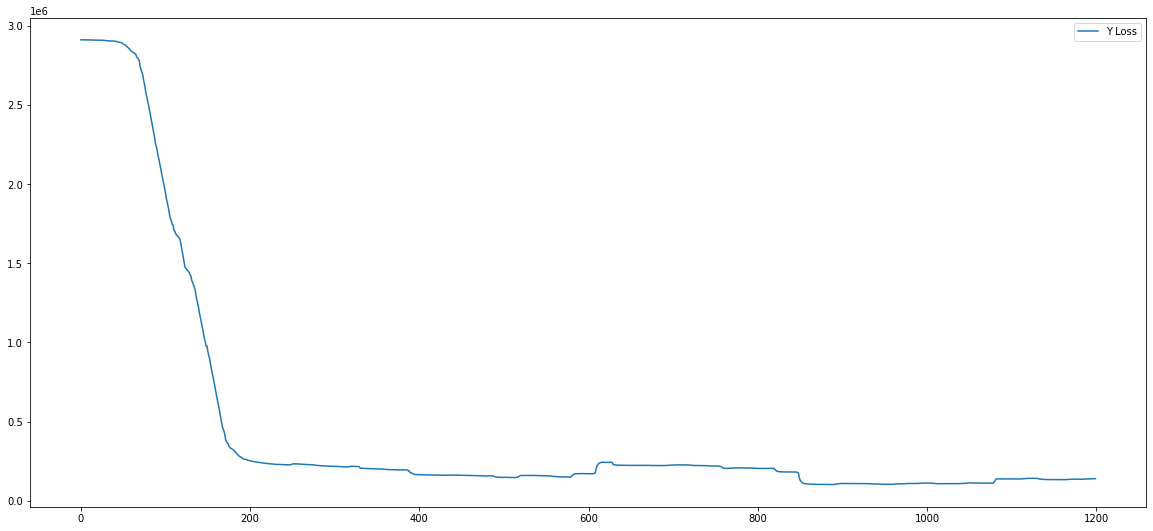

In [651]:
plt.plot(uniform_filter1d([float(v) for v in dy_loss[start_idx:]], size=avg_len), label = "Y Loss")
plt.legend()
plt.show()

# Compare Models

In [652]:
model_idx = {'model':0, 'learning_rate': 1, 'size':2, 'activation':3, 'dropout':4, 'gnn_channels':5,
            'hidden_channels': 6, 'note':7}
idx_model = {v: k for k, v in model_idx.items()}

In [653]:
model_dict = pickle.load(open('model_compare.pkl', 'rb'))

In [654]:
model_dict.keys()

dict_keys(['SAGEConv_0.001_41_LeakyReLU_0.41_2056_2056_lyrs1_wd0.01', 'SAGEConv_0.001_41_LeakyReLU_0.41_1024_2056_lyrs3_wd0.01', 'SAGEConv_0.001_41_LeakyReLU_0.41_512_2056_lyrs3_wd0.01', 'SAGEConv_0.0001_41_LeakyReLU_0.1_256_2056_lyrs8_wd0.01'])

In [655]:
delList = []
for m in model_dict.keys():
    info = {idx_model[i]: v for i, v in enumerate(m.split('_')[:len(model_idx)])}
    info['note'] = '_'.join(m.split('_')[len(model_idx)-1:]) # Merge all trailing notes
    if 'lyrs0' in info['note'] or int(info['size']) <= 1:
        delList += [m]
    
for m in delList:
    del model_dict[m]

In [656]:
def plot_filt(size_min=0, size_max=1, loss_type='loss', avg_len=50, plt_size=(20,3), 
              xmax=None, ymax=None, plt_time=False, filt=None, skip_list=None):
    times = None
    for m, model_tuple in model_dict.items():  
        info = {idx_model[i]: v for i, v in enumerate(m.split('_')[:len(model_idx)])}
        info['note'] = '_'.join(m.split('_')[len(model_idx)-1:]) # Merge all trailing notes
        size = int(info['size'])
        
        if skip_list != None and m in skip_list:
            continue
        
        if filt != None:
            skip = False
            for k, v in filt:
                if info[k] != v:
                    skip = True
                    break
            
            if skip:
                continue
        
        loss_list, val_list, (dx_loss_list, dy_loss_list), times = model_tuple
            
        
        if size >= size_min and size <= size_max:
            
            val_loss_list = [x+y for x, y in zip(dx_loss_list, dy_loss_list)]
            loss_list = val_loss_list if loss_type == 'val_loss' else loss_list
            loss_list = uniform_filter1d(loss_list, size=avg_len)
            
            if plt_time:
                if times == None:
                    continue
                plt.plot(times, loss_list, label = m)
            else:
                plt.plot(loss_list, label = m)
            
                
        
    plt.legend()
    plt.rcParams["figure.figsize"] = plt_size
    if xmax:
        plt.xlim(left=0, right=xmax)
    if ymax:
        plt.ylim(top=ymax, bottom=0)
    plt.show()

In [657]:
from collections import Counter
cnt = Counter()
for k, (_, v, _, _) in model_dict.items():
    cnt[k] = np.mean(v[len(v)//2:])

In [658]:
view_cnt = 5
skip_list = [k for k, v in cnt.most_common()[:-view_cnt] if k != list(model_dict.keys())[-1]]
skip_list

[]

In [659]:
model_dict.keys()

dict_keys(['SAGEConv_0.001_41_LeakyReLU_0.41_2056_2056_lyrs1_wd0.01', 'SAGEConv_0.001_41_LeakyReLU_0.41_1024_2056_lyrs3_wd0.01', 'SAGEConv_0.001_41_LeakyReLU_0.41_512_2056_lyrs3_wd0.01', 'SAGEConv_0.0001_41_LeakyReLU_0.1_256_2056_lyrs8_wd0.01'])

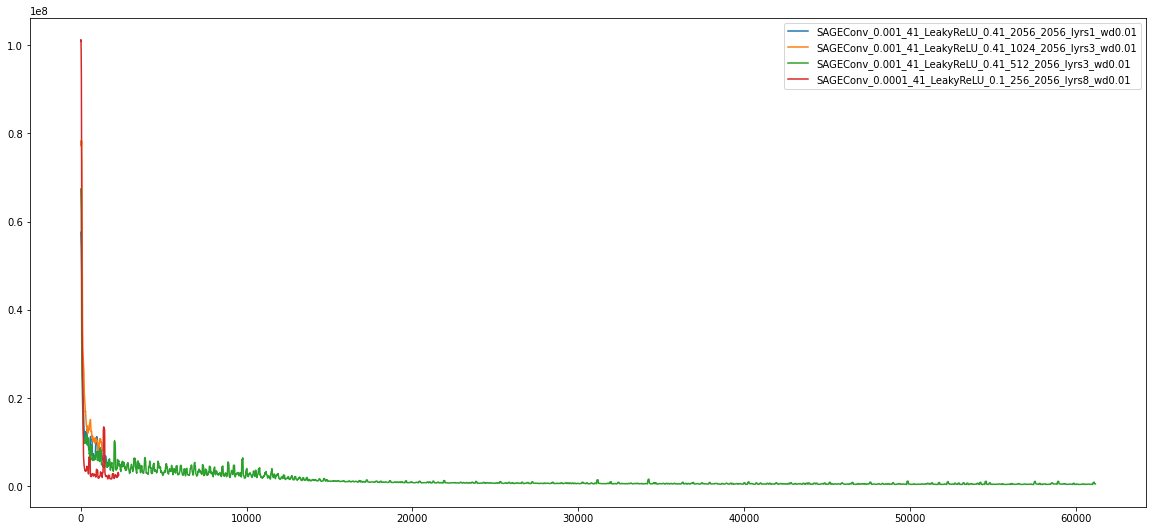

In [663]:
plot_filt(size_min=0, size_max=1000, loss_type='loss', plt_size=(20, 9), plt_time=True, skip_list=skip_list)

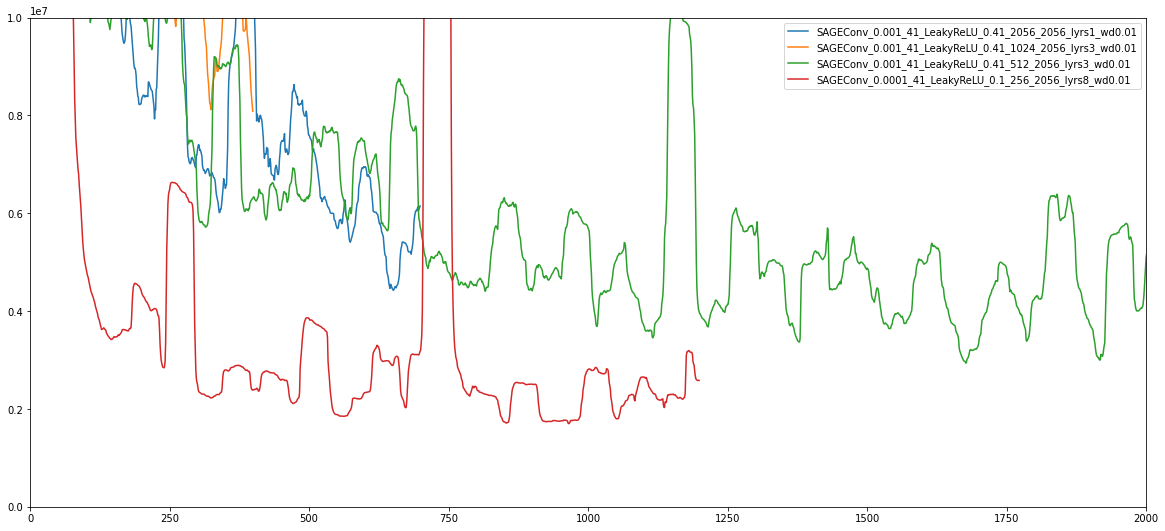

In [664]:
plot_filt(size_min=0, size_max=1000, loss_type='loss', plt_size=(20, 9), xmax=2000, ymax=1e7, skip_list=skip_list)

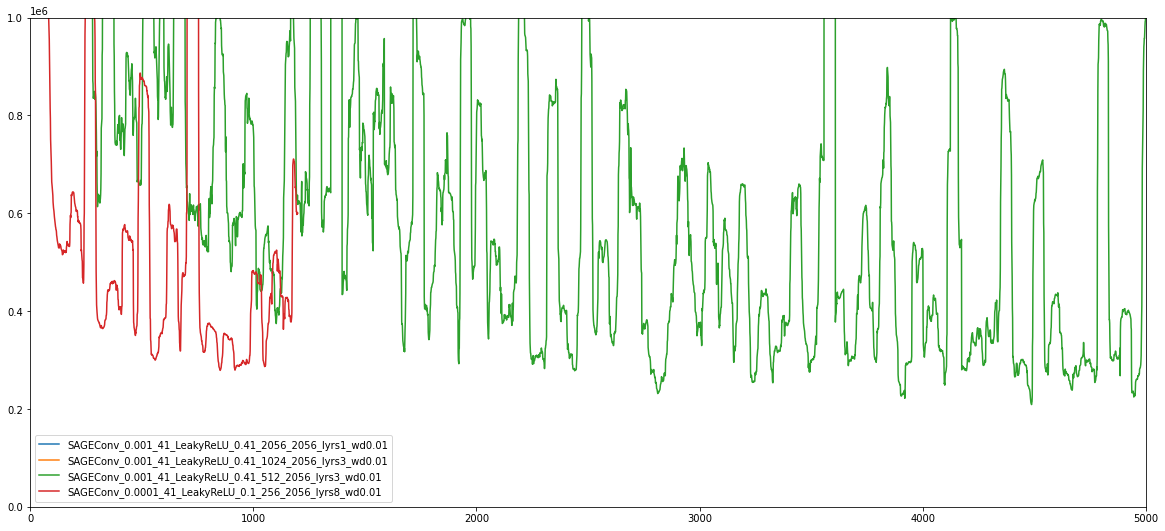

In [665]:
plot_filt(size_min=0, size_max=1000, loss_type='val_loss', plt_size=(20, 9), xmax=5000, ymax=1e6, skip_list=skip_list)

# Visualize Embedding

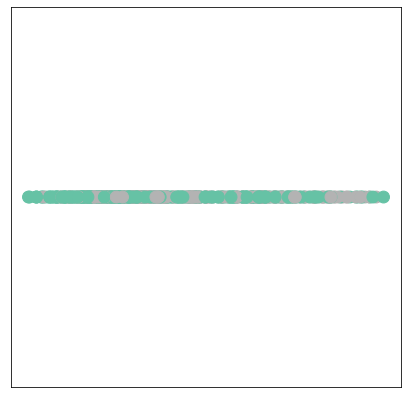

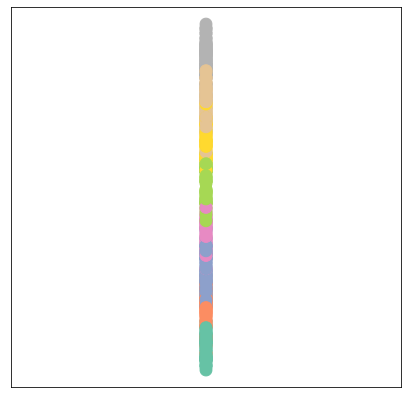

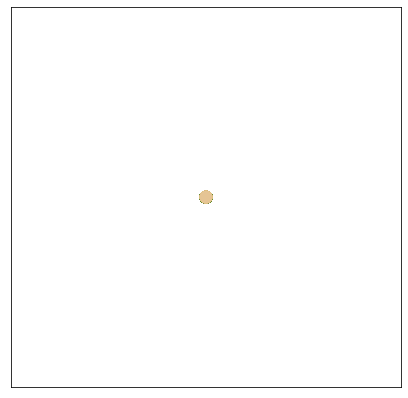

In [624]:
#from torch_geometric.utils import to_networkx
#import networkx as nx

dataset, test_dataset = pickle.load(open('dataset.pkl', 'rb'))

pp = pickle.load(open('preprocessing.pkl', 'rb'))
categorical_dict = pp['categorical_dict']
slk_lbls = pp['slk_lbls']

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
    
idx = [i for i, d in enumerate(dataset) if d['slk'].x.shape[0] == rot_embedding.shape[0]][0]

visualize_embedding(rot_embedding, color=dataset[idx]['slk'].y[:, slk_lbls.index('Y_ROT')])
visualize_embedding(x_embedding, color=dataset[idx]['slk'].y[:, slk_lbls.index('x')])
visualize_embedding(y_embedding, color=dataset[idx]['slk'].y[:, slk_lbls.index('y')])